Get stock data

In [19]:
import yfinance as yf
import pandas as pd

# Download historical data for Apple Inc. from 2015 to today
stock_data = yf.download('AAPL', start='2015-01-01', end=pd.to_datetime('today'))

# We only need the 'Close' price for this project
close_prices = stock_data[['Close']]

C:\Users\Ramakrishna\AppData\Local\Temp\ipykernel_28360\4143733267.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download('AAPL', start='2015-01-01', end=pd.to_datetime('today'))
[*********************100%***********************]  1 of 1 completed


Preprocess the Data

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Create the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data
scaled_data = scaler.fit_transform(close_prices)

create training dataset

In [15]:
# We will use the last 60 days of data to predict the 61st day
prediction_days = 60

X_train = []
y_train = []

# Create the training data
for i in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[i-prediction_days:i, 0])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to be 3D [samples, timesteps, features] as required by LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Build and Train the LSTM Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM Model
model = Sequential()

# Layer 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32)

C:\Users\Ramakrishna\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0164
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0024
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0023
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0023
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0019
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0019
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0019
Epoch 8/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0018
Epoch 9/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0017
Epoch 10/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0016
Epoch 11/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0016
Epoch 12/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0015
Epoch 13/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0016
Epoch 14/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0014
Epoch 15/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0013
Epoc

Make Predictions and Visualize

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\Ramakrishna\AppData\Local\Temp\ipykernel_28360\189729078.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # Add the predictions to the validation dataframe


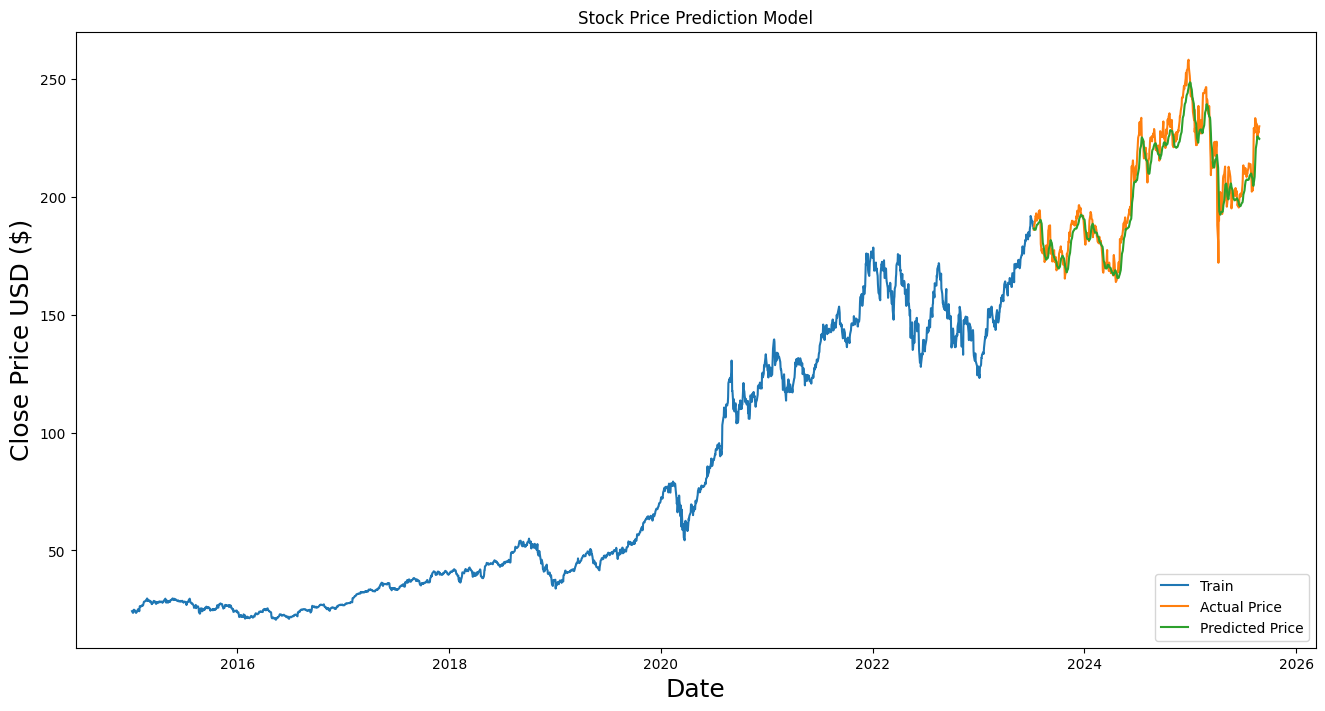

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- Create the Testing Dataset ---

# We will split the data, using 80% for training and the remaining 20% for testing
training_data_len = int(len(scaled_data) * 0.8)

# The test data is the part of the dataset that the model has never seen
test_data = scaled_data[training_data_len - prediction_days:, :]

# Create the test dataset (X_test) and the actual values (y_test)
X_test = []
# These are the actual prices we want to compare against our predictions
actual_prices = close_prices.iloc[training_data_len:].values 

for i in range(prediction_days, len(test_data)):
    X_test.append(test_data[i-prediction_days:i, 0])

# Convert to numpy arrays
X_test = np.array(X_test)

# Reshape the data to be 3D for the LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# --- Make Predictions ---

# Get the model's predicted price values
predictions = model.predict(X_test)

# Inverse the scaling to get the actual dollar values back
predictions = scaler.inverse_transform(predictions)


# --- Visualize the Results ---

# Plot the data
train = close_prices[:training_data_len]
valid = close_prices[training_data_len:]
valid['Predictions'] = predictions # Add the predictions to the validation dataframe

plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual Price', 'Predicted Price'], loc='lower right')
plt.show()